## Topic Modelling

In [1]:
import os
import time
import math
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import bs4
import nltk.corpus  
from nltk.text import Text
import spacy
from pandarallel import pandarallel
import multiprocessing
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
widgets.IntSlider()

pd.set_option('max_colwidth', 200)

import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import string

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

2023-05-24 04:56:02.831509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 04:56:05.850978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-24 04:56:05.851120: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [12]:
%%time
news_df = pd.read_parquet("data_vader_final.parquet", engine ='pyarrow')
news_df.shape

CPU times: user 42.2 s, sys: 9.02 s, total: 51.3 s
Wall time: 41.5 s


(181958, 17)

In [13]:
news_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment'],
      dtype='object')

In [14]:
def tokenize_text(text):
    return nltk.word_tokenize(text)

In [20]:
pandarallel.initialize(nb_workers=62, use_memory_fs = False)

INFO: Pandarallel will run on 62 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
type(news_df['summary'][0])

str

In [19]:
%%time
news_df['summary'] = news_df['summary'].parallel_apply(lambda x: re.sub('[,.]', '', x))

CPU times: user 1.44 s, sys: 10.5 s, total: 11.9 s
Wall time: 12.7 s


In [20]:
%%time
news_df['summary_tokens'] = news_df['summary'].parallel_apply(lambda x: tokenize_text(x))

CPU times: user 11.2 s, sys: 15.3 s, total: 26.4 s
Wall time: 31.2 s


In [21]:
%%time
stopwords = set(nltk.corpus.stopwords.words('english'))
news_df['summary_tokens'] = news_df['summary_tokens'].parallel_apply(lambda x: [token for token in x if token not in stopwords])

CPU times: user 18.5 s, sys: 11.7 s, total: 30.1 s
Wall time: 30 s


In [11]:
# %%time
# news_df['summary_tokens'] = news_df['summary_tokens'].parallel_apply(lambda x: [token.replace(',', '').replace('.', '') for token in x])

CPU times: user 34.7 s, sys: 29.5 s, total: 1min 4s
Wall time: 1min 4s


In [22]:
%%time
news_df.to_parquet('data_final_vader.parquet')

CPU times: user 48.2 s, sys: 8.37 s, total: 56.6 s
Wall time: 1min 17s


In [2]:
%time news_df = pd.read_parquet('data_final_vader.parquet', engine = 'pyarrow')

CPU times: user 52.9 s, sys: 9.52 s, total: 1min 2s
Wall time: 47 s


In [3]:
news_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens'],
      dtype='object')

### Topic Modelling on the entire data

In [4]:
%%time
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_text = corpora.Dictionary(news_df['summary_tokens'])
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_text = [dictionary_text.doc2bow(doc) for doc in news_df['summary_tokens']]

CPU times: user 1min 47s, sys: 1.78 s, total: 1min 49s
Wall time: 1min 49s


In [5]:
%%time
tuned_lda_model_text = LdaMulticore(corpus=doc_term_matrix_text,
                       id2word=dictionary_text,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha='symmetric',
                       eta='auto',
                       workers = 62)

CPU times: user 4min 20s, sys: 55.7 s, total: 5min 16s
Wall time: 4min 59s


In [6]:
pprint(tuned_lda_model_text.print_topics())

[(0,
  '0.039*"Market" + 0.019*"Intelligence" + 0.019*"Artificial" + 0.014*"AI" + '
  '0.012*"Global" + 0.009*"2020" + 0.008*"Analysis" + 0.008*"report" + '
  '0.007*"The" + 0.006*"Growth"'),
 (1,
  '0.024*"AI" + 0.009*"data" + 0.007*"The" + 0.004*"News" + 0.003*"Republic" + '
  '0.003*"new" + 0.003*"intelligence" + 0.003*"said" + 0.003*"learning" + '
  '0.003*"technology"'),
 (2,
  '0.017*"AI" + 0.009*"new" + 0.007*"The" + 0.005*"ChatGPT" + 0.005*"News" + '
  '0.005*"Google" + 0.003*"2023" + 0.003*"Microsoft" + 0.003*"opens" + '
  '0.002*"tab"'),
 (3,
  '0.026*"AI" + 0.006*"The" + 0.005*"data" + 0.004*"technology" + '
  '0.004*"platform" + 0.004*"PRNewswire" + 0.004*"Inc" + 0.004*"Group" + '
  '0.004*"Gray" + 0.004*"Media"'),
 (4,
  '0.019*"AI" + 0.013*"News" + 0.005*"The" + 0.004*"Business" + 0.003*"2022" + '
  '0.003*"Intelligence" + 0.003*"US" + 0.003*"Technology" + 0.002*"Data" + '
  '0.002*"new"'),
 (5,
  '0.022*"US" + 0.010*"All" + 0.009*"Services" + 0.008*"News" + '
  '0.007*"B

In [7]:
%%time

lda_display_text = gensimvis.prepare(tuned_lda_model_text, doc_term_matrix_text, dictionary_text, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_text)

CPU times: user 1min 47s, sys: 9.32 s, total: 1min 57s
Wall time: 2min 25s


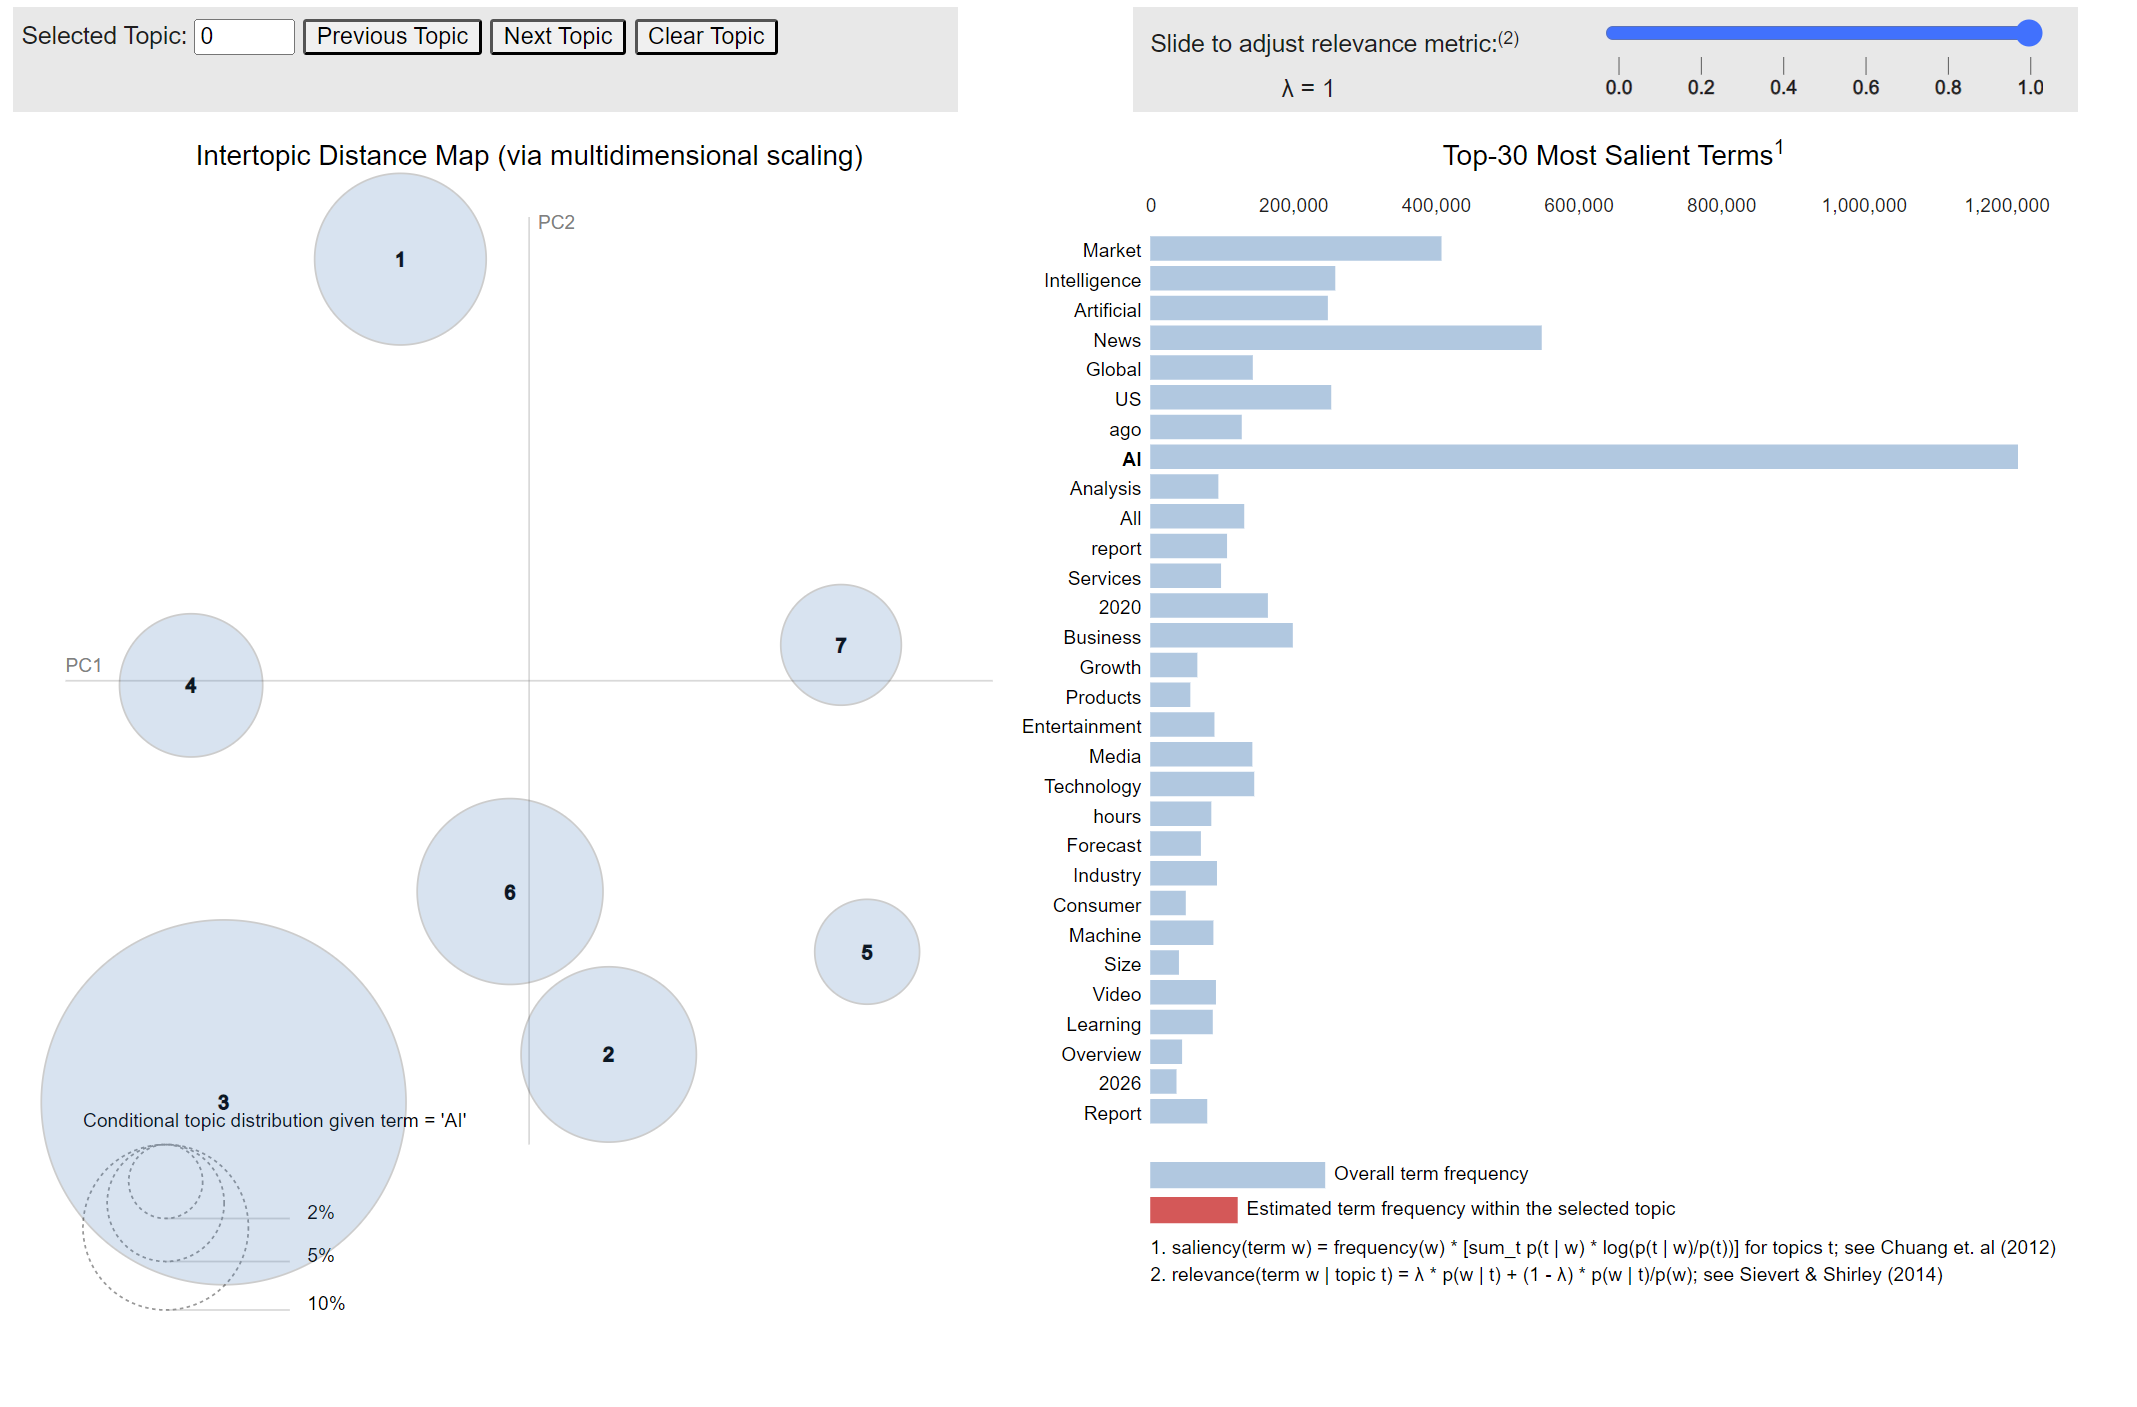
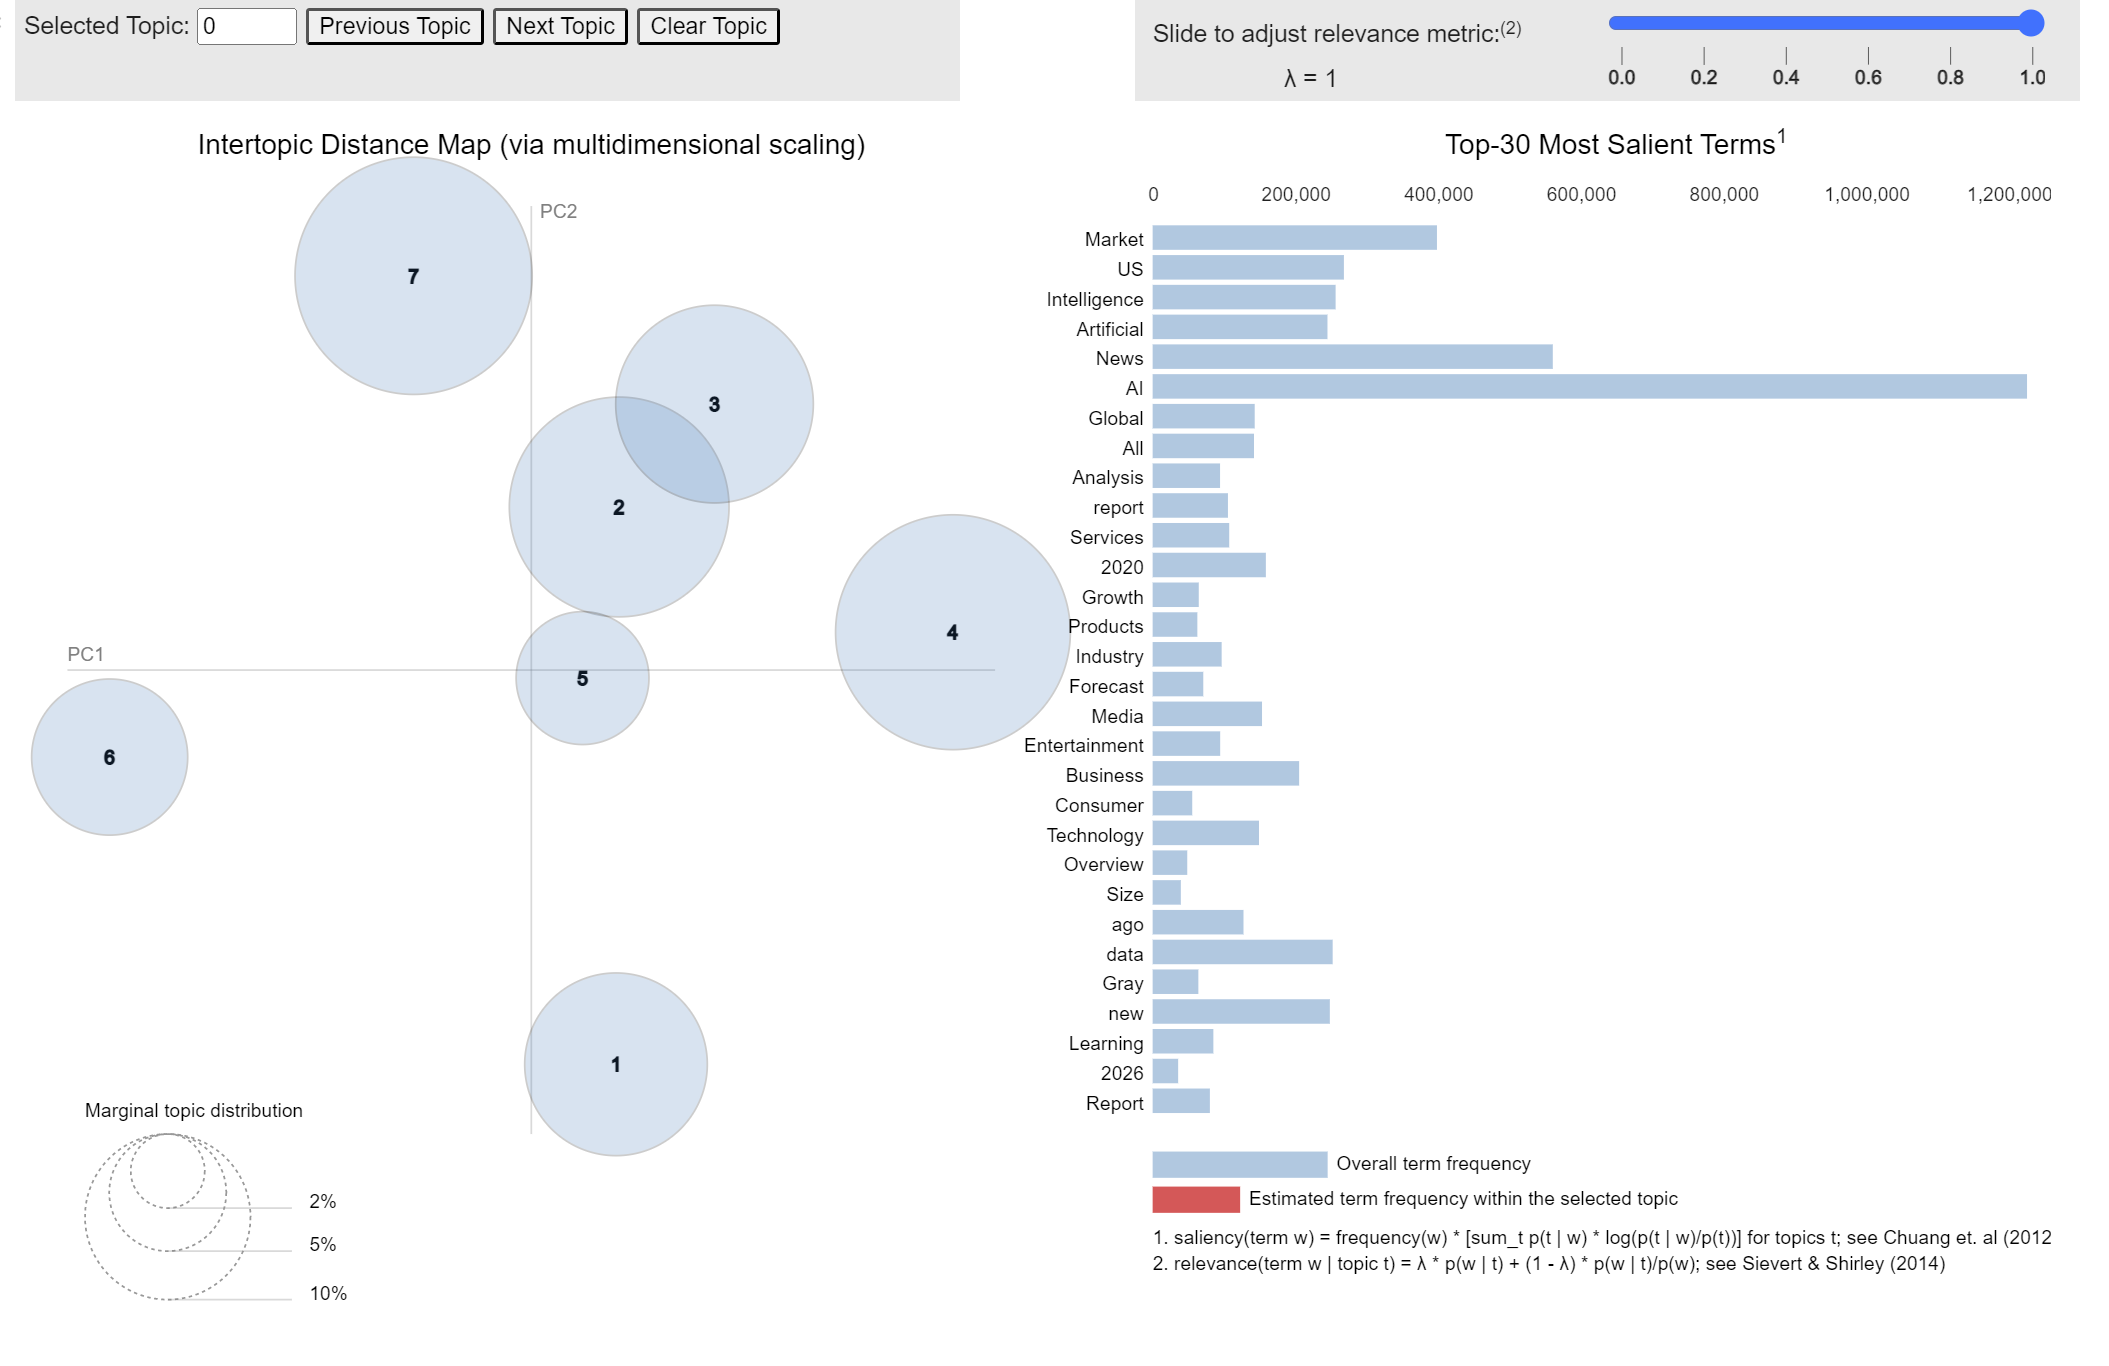

### Topic Modelling on the Positive sentiment articles

In [8]:
news_df.columns

Index(['date', 'month', 'year', 'quarter', 'day', 'dayofwk', 'title', 'text',
       'title_clean', 'text_clean', 'title_tokens', 'text_tokens', 'title_len',
       'text_len', 'summary', 'sent_score', 'sentiment', 'summary_tokens'],
      dtype='object')

In [9]:
pos_df = news_df[news_df['sentiment']=='Positive']
neg_df = news_df[news_df['sentiment']=='Negative']

print(pos_df.shape, '\t', neg_df.shape)

(170643, 18) 	 (11280, 18)


In [10]:
%%time
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_text_pos = corpora.Dictionary(pos_df['summary_tokens'])
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_text_pos = [dictionary_text_pos.doc2bow(doc) for doc in pos_df['summary_tokens']]

CPU times: user 1min 40s, sys: 2.12 s, total: 1min 42s
Wall time: 1min 42s


In [11]:
%%time
tuned_lda_model_text_pos = LdaMulticore(corpus=doc_term_matrix_text_pos,
                       id2word=dictionary_text_pos,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha='symmetric',
                       eta='auto',
                       workers = 62)

CPU times: user 3min 22s, sys: 55.1 s, total: 4min 17s
Wall time: 4min


In [12]:
pprint(tuned_lda_model_text_pos.print_topics())

[(0,
  '0.040*"Market" + 0.020*"Intelligence" + 0.019*"Artificial" + 0.015*"AI" + '
  '0.012*"Global" + 0.009*"2020" + 0.009*"Analysis" + 0.008*"report" + '
  '0.007*"The" + 0.006*"Growth"'),
 (1,
  '0.022*"AI" + 0.008*"News" + 0.005*"The" + 0.004*"Machine" + '
  '0.004*"Learning" + 0.003*"technology" + 0.003*"Inc" + 0.003*"platform" + '
  '0.003*"Media" + 0.002*"2022"'),
 (2,
  '0.019*"US" + 0.010*"All" + 0.008*"AI" + 0.008*"Services" + 0.007*"Media" + '
  '0.007*"News" + 0.007*"Business" + 0.006*"Technology" + 0.006*"Products" + '
  '0.006*"Entertainment"'),
 (3,
  '0.019*"AI" + 0.007*"new" + 0.006*"The" + 0.005*"data" + 0.005*"Republic" + '
  '0.004*"News" + 0.003*"platform" + 0.003*"technology" + 0.003*"solutions" + '
  '0.003*"2022"'),
 (4,
  '0.017*"AI" + 0.009*"News" + 0.008*"The" + 0.005*"new" + 0.004*"ago" + '
  '0.004*"ChatGPT" + 0.003*"Google" + 0.003*"2023" + 0.003*"intelligence" + '
  '0.003*"said"'),
 (5,
  '0.017*"News" + 0.007*"AI" + 0.007*"Business" + 0.006*"The" + 0.0

In [13]:
%%time

lda_display_text_pos = gensimvis.prepare(tuned_lda_model_text_pos, doc_term_matrix_text_pos, dictionary_text_pos, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_text_pos)

CPU times: user 1min 48s, sys: 12.4 s, total: 2min
Wall time: 2min 17s


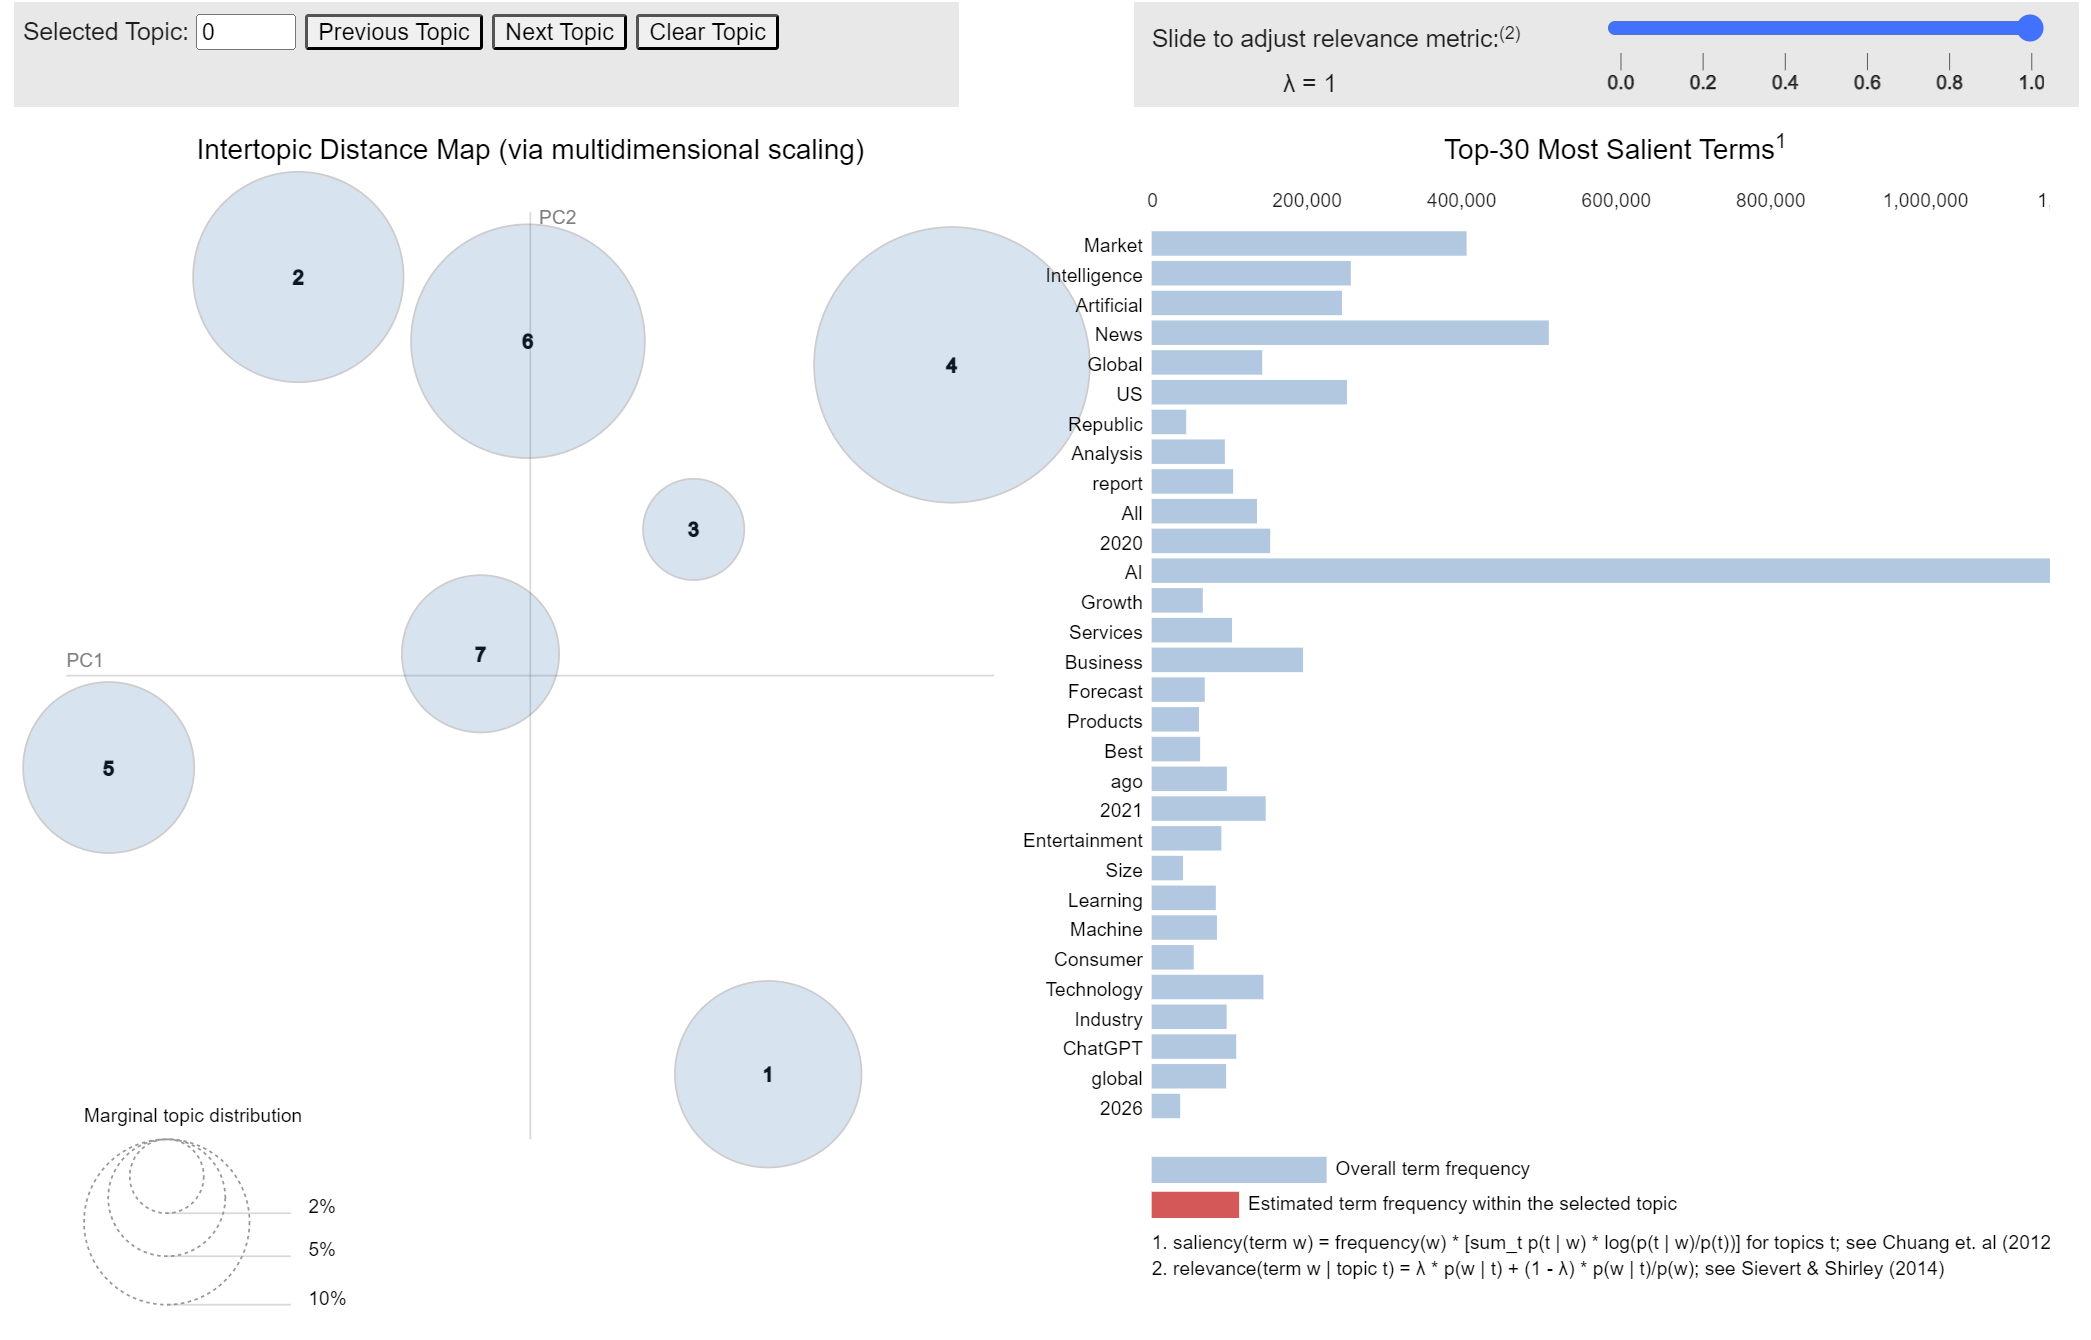
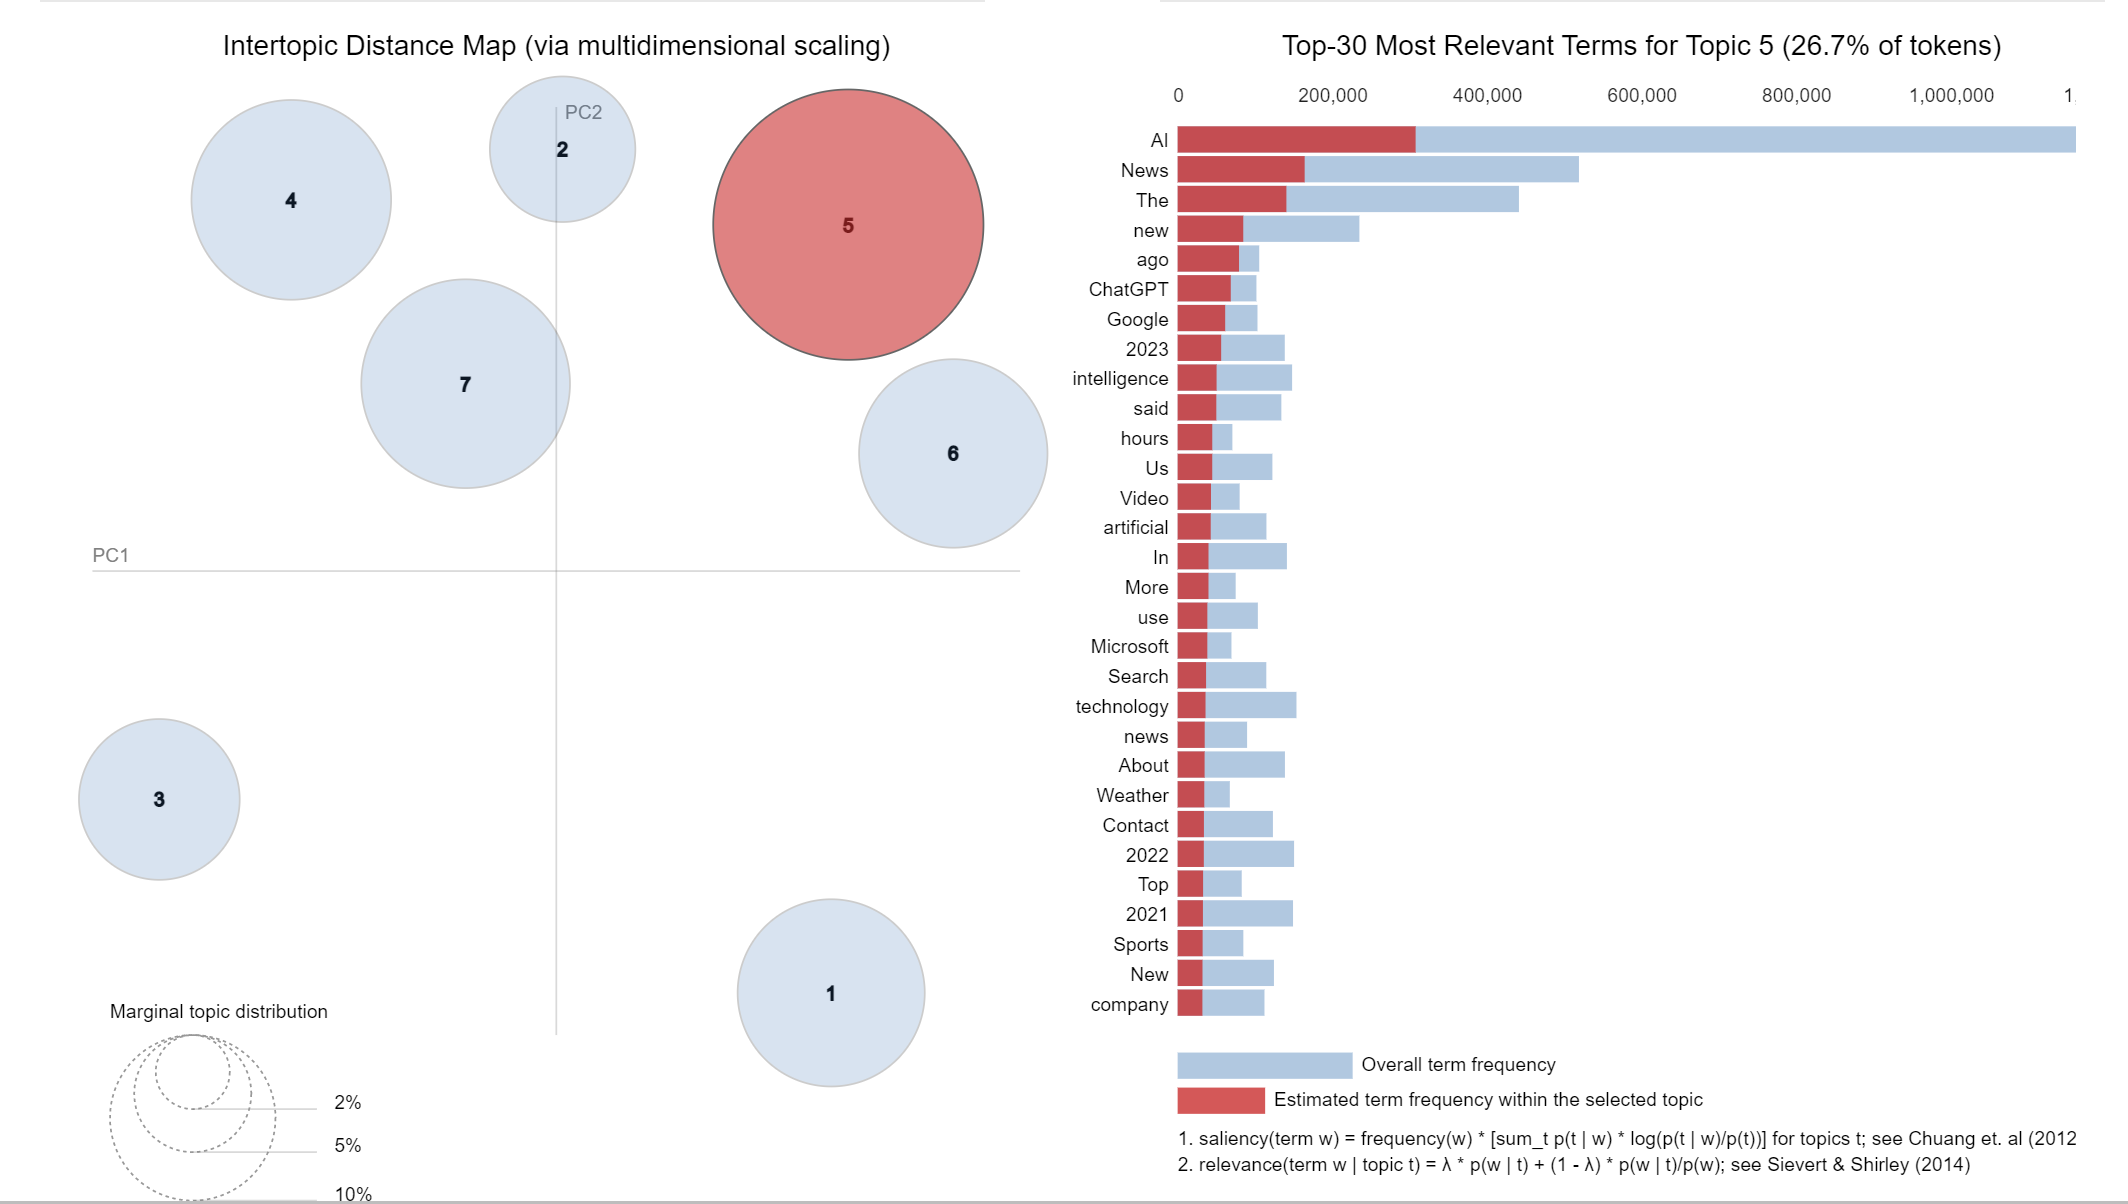
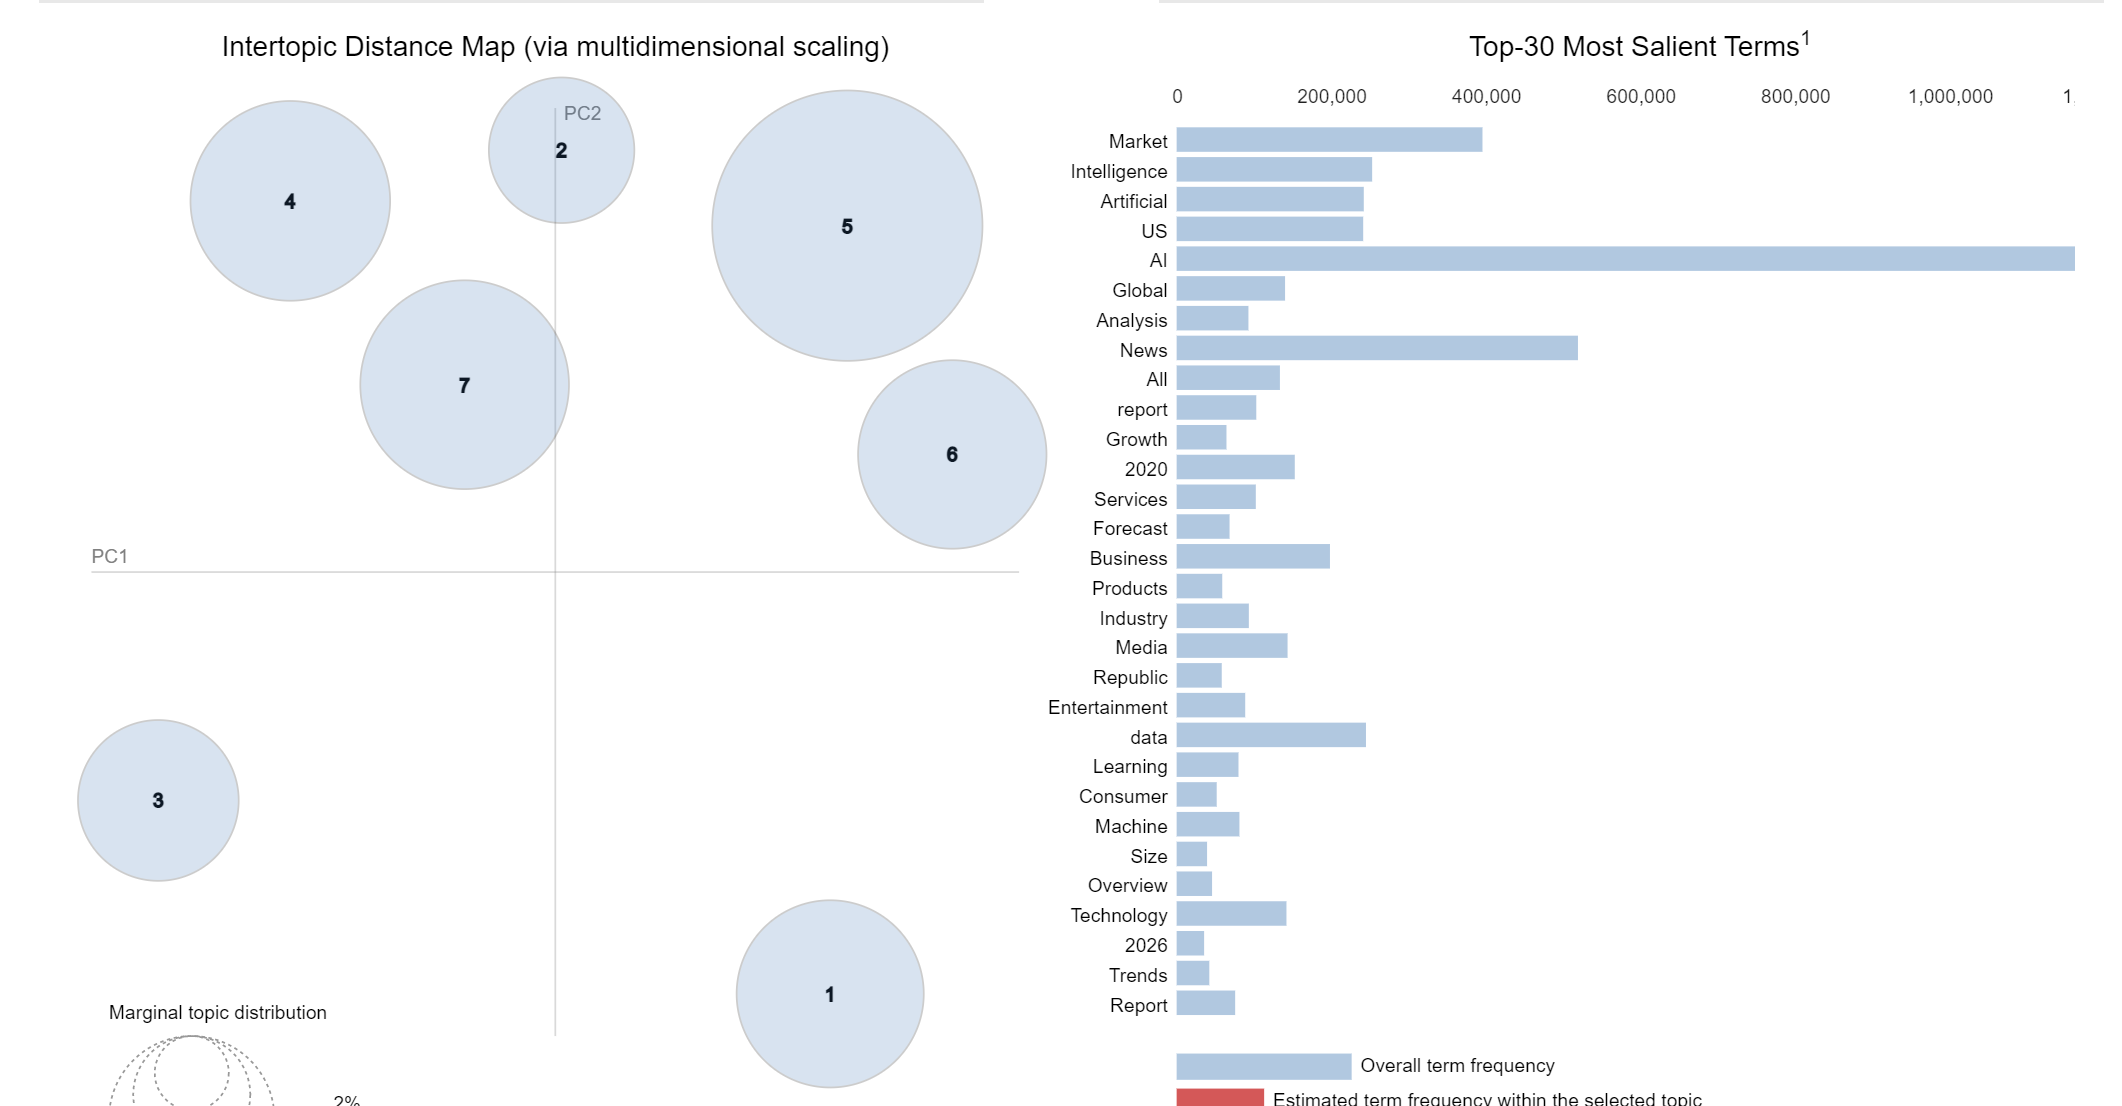

### Topic Modelling on the Negative sentiment articles

In [14]:
%%time
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_text_neg = corpora.Dictionary(neg_df['summary_tokens'])
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_text_neg = [dictionary_text_neg.doc2bow(doc) for doc in neg_df['summary_tokens']]

CPU times: user 6.76 s, sys: 169 ms, total: 6.93 s
Wall time: 6.93 s


In [15]:
%%time
tuned_lda_model_text_neg = LdaMulticore(corpus=doc_term_matrix_text_neg,
                       id2word=dictionary_text_neg,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha='symmetric',
                       eta='auto',
                       workers = 62)

CPU times: user 46.1 s, sys: 12.2 s, total: 58.3 s
Wall time: 57.8 s


In [16]:
pprint(tuned_lda_model_text_neg.print_topics())

[(0,
  '0.018*"AI" + 0.008*"cancer" + 0.007*"The" + 0.005*"new" + 0.003*"Cancer" + '
  '0.003*"technology" + 0.002*"said" + 0.002*"News" + 0.002*"study" + '
  '0.002*"intelligence"'),
 (1,
  '0.018*"News" + 0.010*"Video" + 0.006*"The" + 0.006*"AI" + 0.004*"Us" + '
  '0.004*"US" + 0.004*"Weather" + 0.004*"New" + 0.003*"Sports" + 0.003*"2023"'),
 (2,
  '0.008*"News" + 0.006*"The" + 0.005*"US" + 0.004*"said" + 0.004*"AI" + '
  '0.004*"India" + 0.003*"19" + 0.003*"China" + 0.003*"World" + 0.003*"Jones"'),
 (3,
  '0.022*"AI" + 0.008*"The" + 0.005*"News" + 0.005*"Google" + 0.004*"said" + '
  '0.004*"new" + 0.004*"ChatGPT" + 0.003*"data" + 0.003*"company" + '
  '0.003*"intelligence"'),
 (4,
  '0.017*"News" + 0.006*"The" + 0.005*"new" + 0.005*"AI" + 0.005*"Sports" + '
  '0.005*"Bing" + 0.004*"Us" + 0.004*"Business" + 0.003*"said" + '
  '0.003*"Local"'),
 (5,
  '0.023*"ago" + 0.018*"News" + 0.013*"hours" + 0.009*"Stories" + '
  '0.008*"Video" + 0.007*"Weather" + 0.007*"Top" + 0.006*"More" + 0.0

In [17]:
%%time

lda_display_text_neg = gensimvis.prepare(tuned_lda_model_text_neg, doc_term_matrix_text_neg, dictionary_text_neg, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_text_neg)

CPU times: user 7.6 s, sys: 118 ms, total: 7.71 s
Wall time: 14.2 s


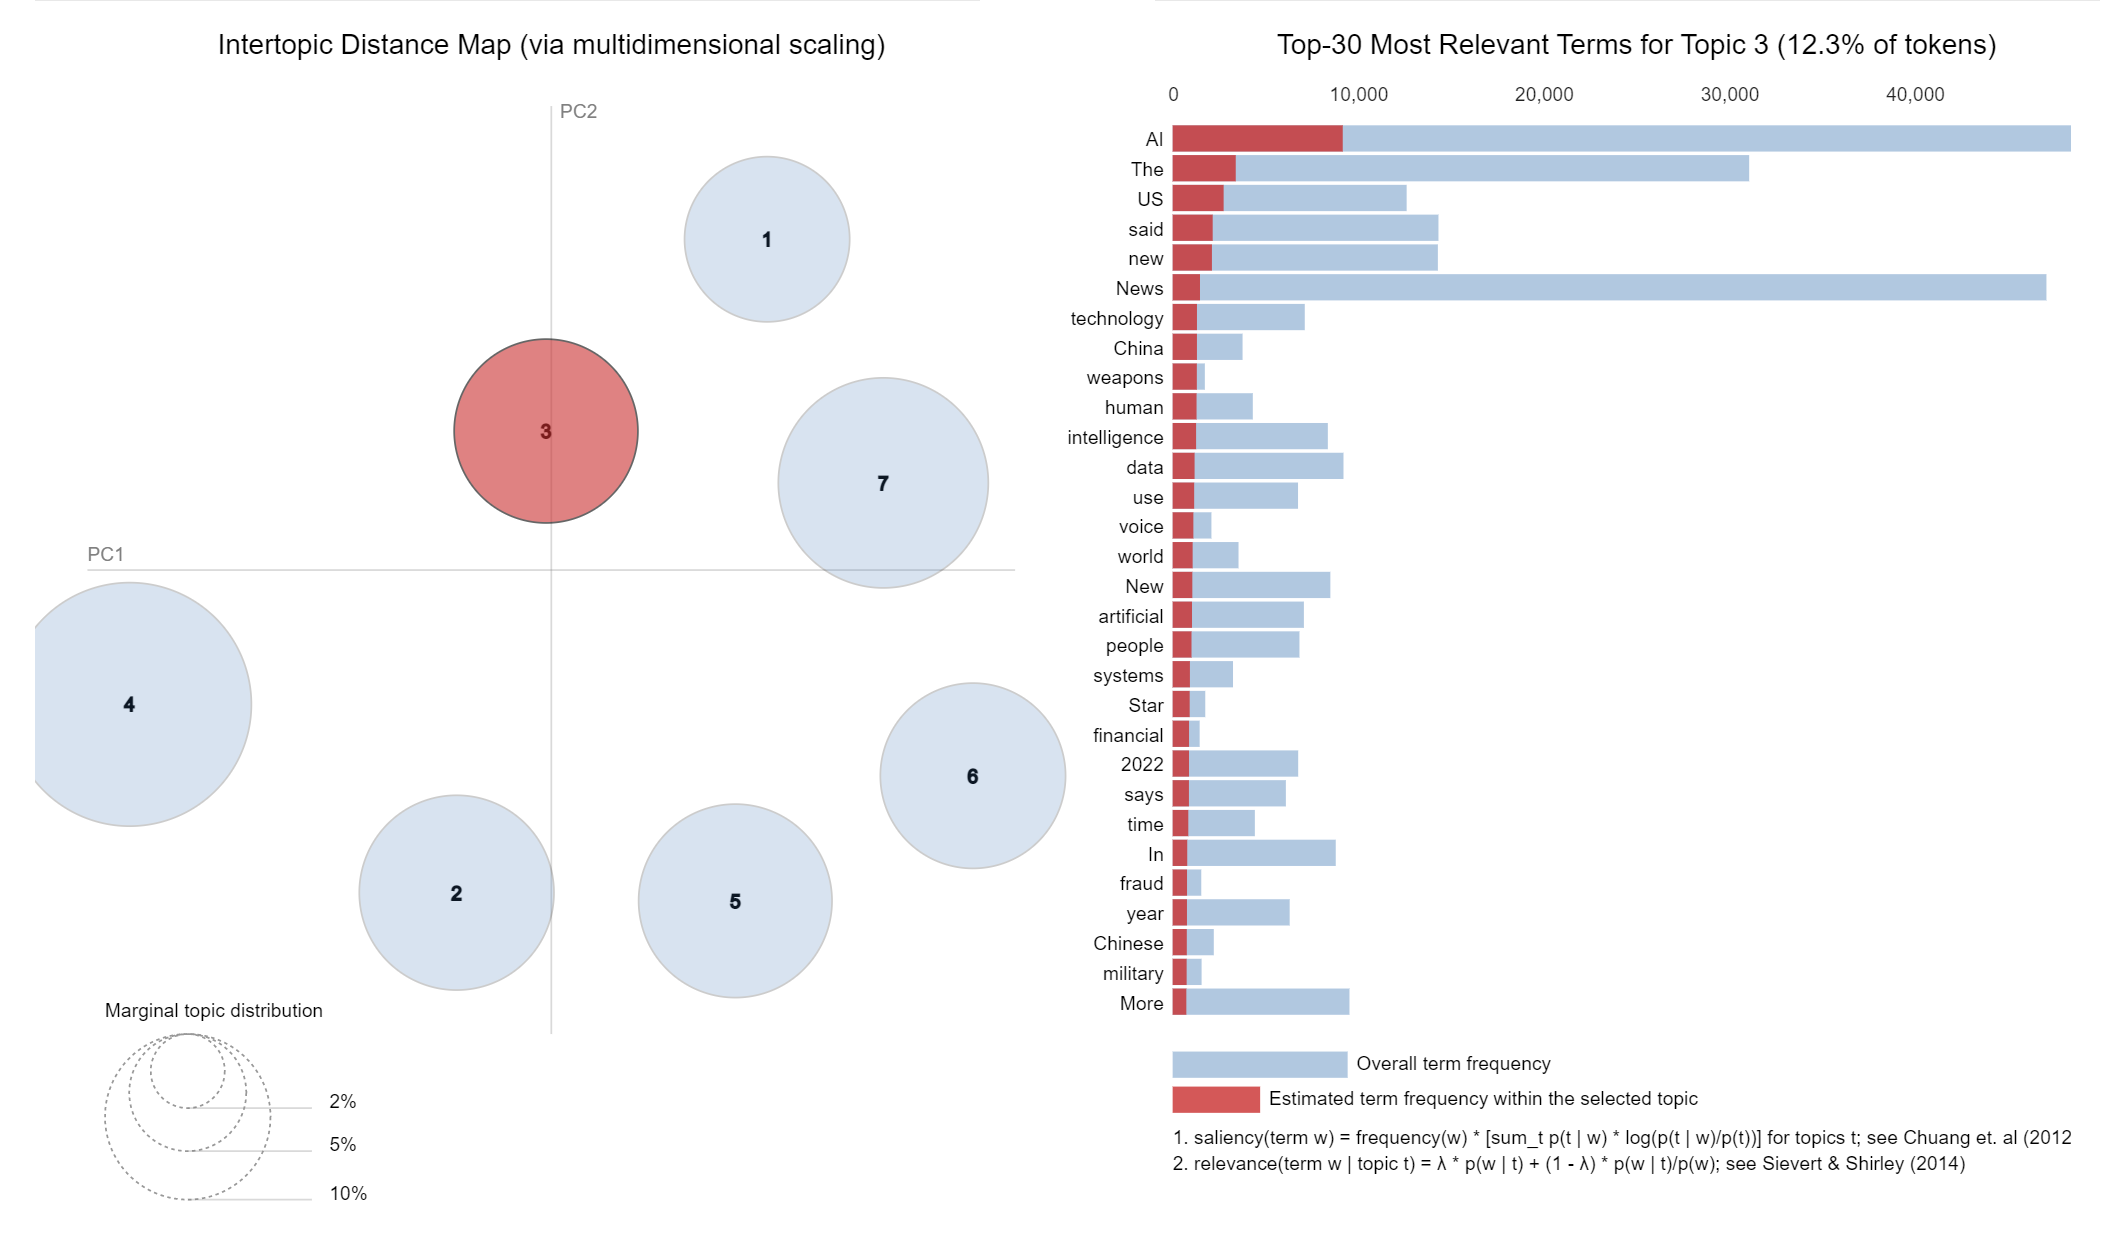
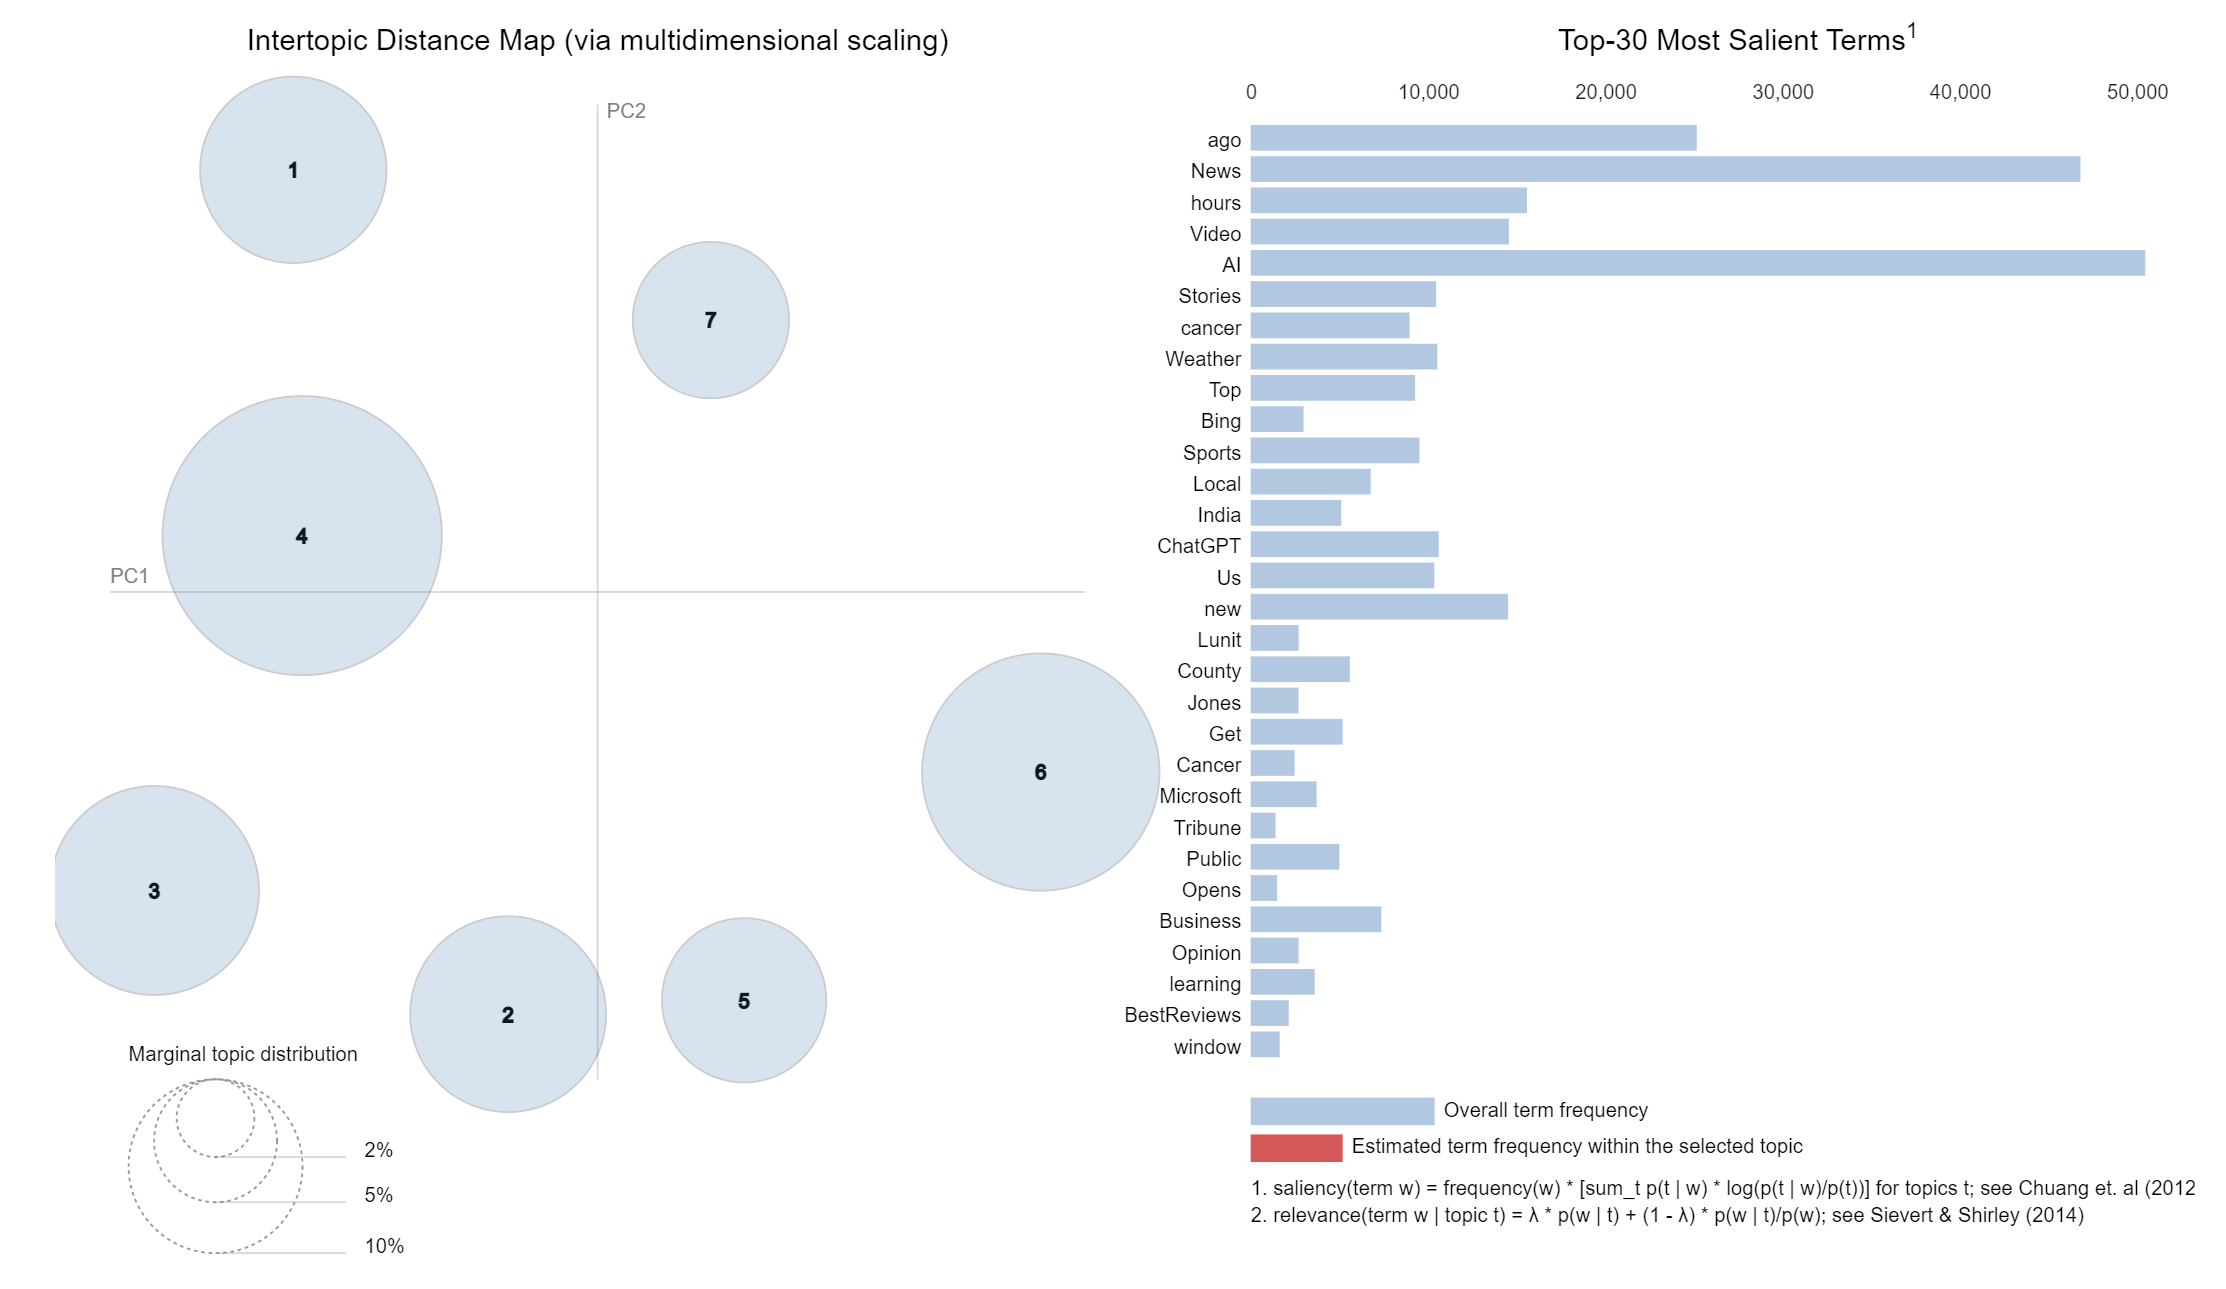

In [44]:
from nbconvert import HTMLExporter
exporter = HTMLExporter()


In [45]:
notebook_file = 'NLP_Final_7.ipynb'
output_file = 'NLP_Final_7.html'
output, _ = exporter.from_filename(notebook_file)
with open(output_file, 'w') as f:
    f.write(output)

In [46]:
import datetime
import time
import pytz
datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Wed, 24 May 2023 01:04:50'